# Imports

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Loading The Dataset

In [2]:
file_path = 'CrossCheck_Daily_Data.xlsx'  
data = pd.read_excel(file_path)

print("Dataset Shape:", data.shape)
print("Column Names:", data.columns)
print(data.head())

Dataset Shape: (23573, 155)
Column Names: Index(['study_id', 'eureka_id', 'day', 'act_in_vehicle_ep_0',
       'act_in_vehicle_ep_1', 'act_in_vehicle_ep_2', 'act_in_vehicle_ep_3',
       'act_in_vehicle_ep_4', 'act_on_bike_ep_0', 'act_on_bike_ep_1',
       ...
       'unlock_duration_ep_0', 'unlock_duration_ep_1', 'unlock_duration_ep_2',
       'unlock_duration_ep_3', 'unlock_duration_ep_4', 'unlock_num_ep_0',
       'unlock_num_ep_1', 'unlock_num_ep_2', 'unlock_num_ep_3',
       'unlock_num_ep_4'],
      dtype='object', length=155)
   study_id eureka_id       day  act_in_vehicle_ep_0  act_in_vehicle_ep_1  \
0        -1      u004  20150122                    0                    0   
1        -1      u004  20150123                    0                    0   
2        -1      u004  20150124                    0                    0   
3        -1      u004  20150125                    0                    0   
4        -1      u004  20150126                    0                    0   

# Data Aggregation

In [3]:
#Aggregate the eps to make it one full day
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

new_columns = []
processed_base_columns = set()  
columns_to_drop = []  


epochs = ['ep_0', 'ep_1', 'ep_2', 'ep_3']  #only taking the first four eps as they indicates the whole day


for col in numerical_cols:
    if any(epoch in col for epoch in epochs):  # to see if the coulmn has ep_ in it 
        
        #removing ep for the bas coulmn name
        epoch_num = [epoch for epoch in epochs if epoch in col][0]
        base_col_name = col.replace(f'_{epoch_num}', '') 

        # Check if the coulmn has been aggregated before and not aggregate ep_4 
        if base_col_name not in processed_base_columns:
            columns_to_sum = [col for col in data.columns if base_col_name in col and 'ep_4' not in col]
            aggregated_col = data[columns_to_sum].sum(axis=1)
            new_columns.append(aggregated_col.rename(base_col_name + '_sum'))
            

            columns_to_drop.extend([col for col in columns_to_sum if 'ep_4' not in col]) 

            # Mark the base column as processed
            processed_base_columns.add(base_col_name)

# add the new coulmns to the data 
if new_columns:
    data = pd.concat([data] + new_columns, axis=1)

#drop the original coulmns 
data.drop(columns=columns_to_drop, inplace=True)

# Creating Sub-dataset

In [4]:
# Identify rows with recorded EMA scores
data['is_target'] = data['ema_score'].notna()

# Find the indices where EMA scores are available
ema_indices = data[data['is_target']].index.tolist()

# List to store new dataset rows
new_data = []

# Extract feature columns (excluding 'ema_score', 'study_id', 'eureka_id', and 'day')
feature_cols = [col for col in data.columns if col not in ['ema_score', 'study_id', 'eureka_id', 'day', 'is_target']]

# Iterate over each EMA segment
for i in range(len(ema_indices) - 1):
    start_idx = ema_indices[i]  # Start from last recorded EMA
    end_idx = ema_indices[i + 1]  # Stop at next recorded EMA

    # Get segment data
    segment = data.iloc[start_idx:end_idx]

    # Compute average of feature columns
    avg_features = segment[feature_cols].mean().to_dict()

    # Assign the next recorded EMA score as the target
    avg_features['ema_score'] = data.loc[end_idx, 'ema_score']

    # Store metadata
    avg_features['study_id'] = data.loc[start_idx, 'study_id']  # Keep the participant ID
    avg_features['start_day'] = data.loc[start_idx, 'day']  # First day in the segment
    avg_features['end_day'] = data.loc[end_idx, 'day']  # Last day in the segment

    # Store the result
    new_data.append(avg_features)

# Convert new dataset to DataFrame
data = pd.DataFrame(new_data)

# Data Cleaning

In [5]:
data = data.loc[:, data.nunique() > 1]
data.fillna(data.mean(), inplace=True)
print(data)

      act_in_vehicle_ep_4  act_on_bike_ep_4  act_on_foot_ep_4  act_still_ep_4  \
0                0.000000          0.000000          0.000000    21600.000000   
1             1434.500000         52.000000        211.000000    19785.000000   
2              701.142857          3.000000        296.142857    19977.142857   
3              957.666667         10.333333         57.000000    20424.666667   
4              594.500000         52.500000       1321.500000    18899.500000   
...                   ...               ...               ...             ...   
6358          3510.000000         36.666667        798.666667    14936.333333   
6359          2012.500000         16.500000       1061.000000    16086.500000   
6360          8275.000000         63.500000       1354.500000     7828.000000   
6361          7850.666667         35.333333        752.000000     9019.333333   
6362          8955.000000         24.000000        426.500000     7956.000000   

      act_tilting_ep_4  act

# Featuer Engneering

In [6]:
data['ema_score_lag_1'] = data['ema_score'].shift(1)
data['ema_score_lag_7'] = data['ema_score'].shift(7)
data['start_day'] = pd.to_datetime(data['start_day'])
data['end_day'] = pd.to_datetime(data['end_day'])
data['day_diff'] = (data['end_day'] - data['start_day']).dt.days
data['day_of_week'] = data['start_day'].dt.dayofweek
data['month'] = data['start_day'].dt.month
data['day'] = data['start_day'].dt.day
data['weekofyear'] = data['start_day'].dt.isocalendar().week
data = data.dropna()

# Time-based train/test split

In [7]:
features = data.drop(['ema_score', 'study_id', 'start_day', 'end_day'], axis=1)
target = data['ema_score']
train_size = int(len(data) * 0.8)
X_train = features.iloc[:train_size]
X_test = features.iloc[train_size:]
y_train = target.iloc[:train_size]
y_test = target.iloc[train_size:]

# Featuer Scalling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM Initializing

In [9]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Model Training

In [10]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 55.0874 - mae: 5.8779 - val_loss: 12.4273 - val_mae: 2.6553
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.1990 - mae: 2.5835 - val_loss: 10.9994 - val_mae: 2.3857
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7867 - mae: 2.3994 - val_loss: 9.0808 - val_mae: 2.1462
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0624 - mae: 2.1443 - val_loss: 7.9387 - val_mae: 1.9997
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6850 - mae: 2.0811 - val_loss: 8.5727 - val_mae: 2.1256
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3654 - mae: 2.0559 - val_loss: 7.5942 - val_mae: 1.8993
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7637 - mae: 1.9612 - val_loss: 7.5500 - val_mae: 2.0527
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5122 - mae: 1.9335 - val_loss: 7.2269 - val_mae: 1.9455
Epoch 9/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

# Evaluation

In [11]:

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
mse = mean_squared_error(y_test, model.predict(X_test_scaled))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"✅ Test MAE: {mae:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 3.5565
MSE: 12.6485
✅ Test MAE: 2.5500


# visualization

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


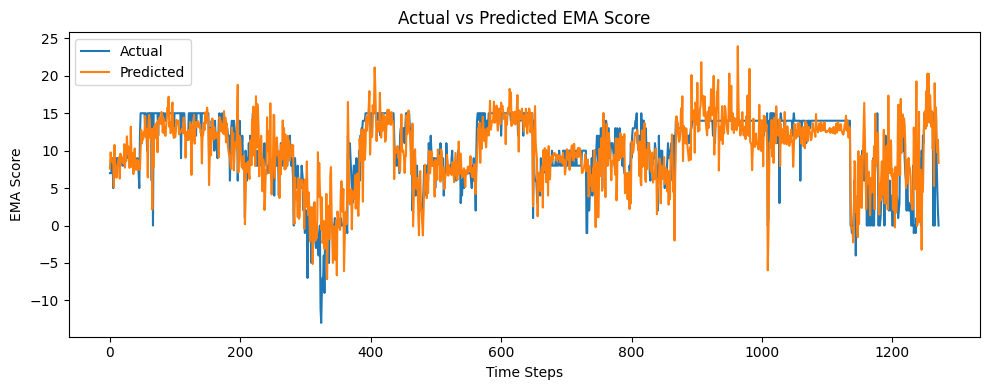

In [12]:
y_pred = model.predict(X_test_scaled).flatten()
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted EMA Score')
plt.xlabel('Time Steps')
plt.ylabel('EMA Score')
plt.legend()
plt.tight_layout()
plt.show()

# Hyper-Parameter Tuning

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(
        LSTM(
            units=hp.Int('units_lstm', min_value=32, max_value=128, step=32),
            activation='relu',
            input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
        )
    )
    model.add(Dense(
        units=hp.Int('units_dense', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model


In [14]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='ema_score_prediction'
)

Reloading Tuner from lstm_tuning\ema_score_prediction\tuner0.json


In [15]:
tuner.search(
    X_train_scaled, y_train,
    epochs=30,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    verbose=1
)

# Evaluation

In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate
loss, mae = best_model.evaluate(X_test_scaled, y_test)
mse = mean_squared_error(y_test, best_model.predict(X_test_scaled))
rmse = np.sqrt(mse)

print(f"✅ Best Model - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1286 - mae: 1.7332   
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
✅ Best Model - RMSE: 2.7565, MAE: 1.8876


# visualization

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


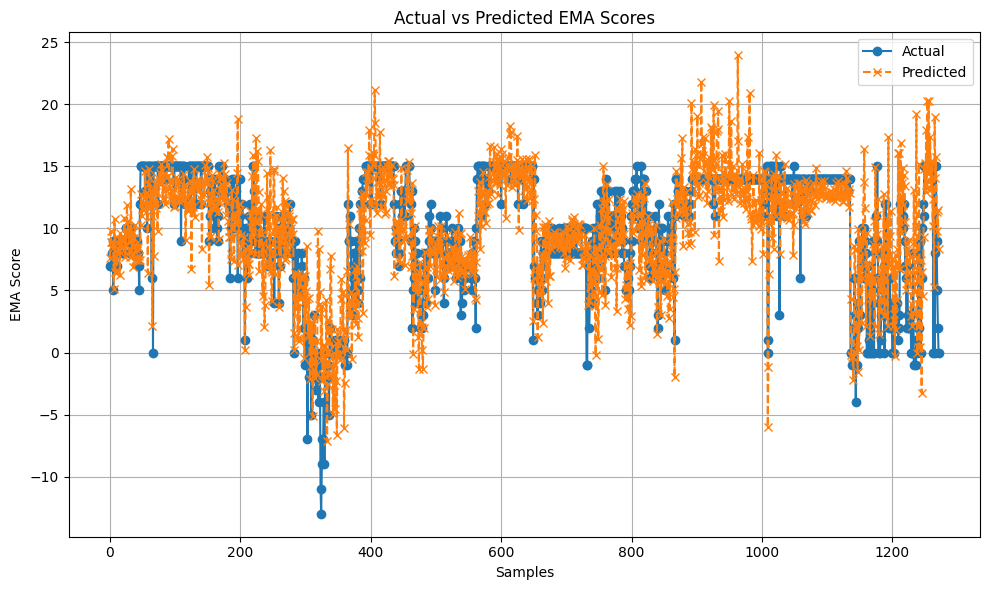

In [17]:
y_pred = model.predict(X_test_scaled)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='o', linestyle='-')
plt.plot(y_pred.flatten(), label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted EMA Scores')
plt.xlabel('Samples')
plt.ylabel('EMA Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()